<a href="https://colab.research.google.com/github/s-ayush2903/xai-btp/blob/master/xai_mseval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-ps38267c
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-ps38267c
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 419 kB 28.3 MB/s 
     |████████████████████████████████| 322 kB 69.4 MB/s 
     |████████████████████████████████| 69 kB 8.5 MB/s 
     |████████████████████████████████| 5.9 MB 68.4 MB/s 
     |████████████████████████████████| 66 kB 5.5 MB/s 
     |████████████████████████████████| 107 kB 74.1 MB/s 
     |████████████████████████████████| 235 kB 69.6 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 55 kB 4.

In [5]:

# Our ML things
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset

from captum.attr import IntegratedGradients
from pytorch_lightning import seed_everything
from pytorch_lightning import Trainer
# Visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Utils
from enum import Enum
import pandas as pd
from sklearn.metrics import classification_report


# Simple enum that helps organizing
# Not really important
class TrainType(Enum):
    train = 1
    test = 2


# Our Custom Dataset class
class RMSTitanic(Dataset):
    def __init__(self, type: TrainType):
        file = "data/train.csv"
        # Preprocessing
        df = pd.read_csv(file)
        # Select relevant fields
        df = df[['Survived', 'Pclass',
                 "Sex", "Age", "SibSp",
                 "Fare"]]
        # Convert Sex -> 0/1
        m = {'male': 1, 'female': 0}
        df['Sex'] = df[
            'Sex'].str.lower().map(m)
        # Fix the non available vals
        # Also normalize
        df = df.fillna(df.median())
        df -= df.min()
        df /= df.max()
        # The first 80% are Train
        if type == TrainType.train:
            self.df = df.loc[:int(
                0.8 * len(df))]
        if type == TrainType.test:
            self.df = df.loc[int(
                0.8 * len(df)):]
        # We will use this later for interpretation
        self.base = torch.tensor(df[
                                     [
                                         'Pclass',
                                         "Sex",
                                         "Age",
                                         "SibSp",
                                         "Fare"]
                                 ].mean()).cuda().float()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        # This function return the i-th elem
        row = self.df.iloc[item]
        label = row['Survived']
        features = row[['Pclass', "Sex",
                        "Age", "SibSp",
                        "Fare"]]
        # return the (label,features)
        return (
            torch.tensor(
                features).cuda().float(),
            torch.tensor(
                label).cuda().float()
        )




In [6]:
# model
class MyHeartWillGoOn(
    pl.LightningModule):

    def __init__(self):
        # Setting up our model
        super().__init__()
        # way to fancy model
        self.lr = 0.01
        self.batch_size = 512
        l1 = 128

        # We send our 5 features into first layer
        self.input = torch.nn.Linear(5,
                                     l1)
        # PRELU is just a fancy activation function
        self.r1 = torch.nn.PReLU()
        # More Layers
        self.l1 = torch.nn.Linear(l1,
                                  l1)
        self.r2 = torch.nn.PReLU()
        self.out = torch.nn.Linear(l1,
                                   1)
        # Befor the Output use a sigmoid
        self.sigmoid = torch.nn.Sigmoid()
        # Define loss
        self.criterion = torch.nn.BCELoss()

    def forward(self, x):
        # Heart of our model
        x = self.input(x) #.to('cuda:0')
        x = self.l1(x)
        x = self.r1(x)
        x = self.out(x)
        x = self.r2(x)
        x = self.sigmoid(x)

        return x

    def train_dataloader(self):
        # Load our Dataset: TRAIN
        return DataLoader(
            RMSTitanic(
                type=TrainType.train),
            batch_size=self.batch_size,
            shuffle=True)

    def val_dataloader(self):
        # Load our Dataset: TEST
        # Simplification: TEST=VAL
        return DataLoader(
            RMSTitanic(
                type=TrainType.test),
            batch_size=self.batch_size,
            shuffle=False)

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.lr)

    def training_step(self, batch,
                      batch_idx):
        # Here we just log some basics
        # We can look at them later in tensorboard
        x, y = batch
        y_hat = self(x)
        y = torch.reshape(y, (
            y.size()[0], 1))
        loss = self.criterion(y_hat, y)
        tensorboard_logs = {
            'loss': loss}
        return {'loss': loss,
                'log': tensorboard_logs}



In [7]:
if __name__ == '__main__':
    to_be_df = []
    max_epoch = 20
    # Seed so we can reproduce
    seed_everything(404)
    # Load model to GPU
    device = torch.device("cuda")
    model = MyHeartWillGoOn().to(device)
    # Make the Trainer do the work
    trainer = Trainer(max_epochs=max_epoch,
                      min_epochs=1,
                      auto_lr_find=True)
    trainer.fit(model)
    # Accuracy #ToBeMeasured
    ts = RMSTitanic(TrainType.test)
    # Bit of Hacking
    x = torch.stack(
        [ts.__getitem__(i)[0] for i in
        # [ts.__getitem__(i)[0].to(device) for i in
         range(ts.__len__())]
    )#.cpu().detach().numpy()
    x = x.to(device)
    y = torch.stack(
        [ts.__getitem__(i)[1] for i in
         range(ts.__len__())]
    ).cpu().detach().numpy()
    # # print(y.device())
    # y = torch.from_numpy(y).float().to(device)
    # # x = torch.from_numpy(x).float().to(device)
    # print(y.device)
    y_hat = model.forward(x.to('cpu')).detach().cpu().numpy()
    y_hat = torch.from_numpy(y_hat).float().to(device)
    y_hat = (y_hat > 0.5)
    y = torch.from_numpy(y).float().to(device)
    x.to(device)
    # # Accuracy and other metrics
    print("REPORT:\n",
          classification_report(y.to('cpu'), y_hat.to('cpu')))
          # classification_report(y.detach().cpu().numpy(), y_hat))

    # Let's start with the interpretation
    STEP_AMOUNT = 50
    SAMPLE_DIM = 5

INFO:lightning_lite.utilities.seed:Global seed set to 404
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:179: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:100: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params
-

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


REPORT:
               precision    recall  f1-score   support

         0.0       0.83      0.92      0.88       115
         1.0       0.83      0.67      0.74        64

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.83       179



IN X1: tensor([1.0000, 1.0000, 0.3466, 0.0000, 0.0303], device='cuda:0')
IMPORTANCE X_m: tensor([-0.0726, -0.1146,  0.0025,  0.0133, -0.0028], device='cuda:0',
       dtype=torch.float64)
Probability SURVIVAl X_m: tensor([[0.1442]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
Let's Change the gender ->X2
IMPORTANCE X_f: tensor([-0.1479,  0.4265,  0.0048,  0.0272, -0.0055], device='cuda:0',
       dtype=torch.float64)
Probability SURVIVAl  X_f: tensor([[0.6224]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
********************************
Index(['Unnamed: 0', 'base-type', 'feature', 'value', 'epoch'], dtype='object')
)))))))))))))))))))))))00
^^^^^^^^^^^^^^^^^^^^^
Index(['base-type', 'feature', 'epoch', 'value'], dtype='object')
---------------------------------------------------------------------
['base-type', 'feature', 'epoch', 'value']
We will plot:
 feature         Age      Fare   Pclass       Sex    SibSp
base-type                                                
mean-b

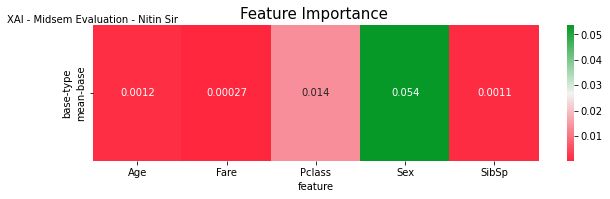

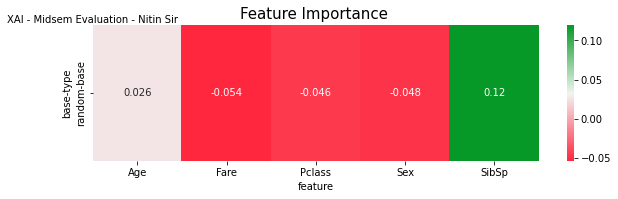

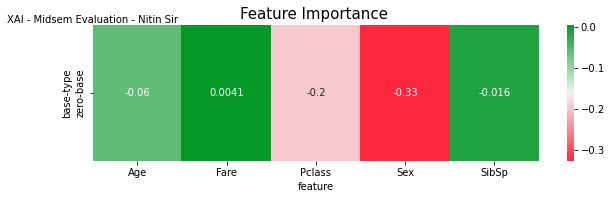

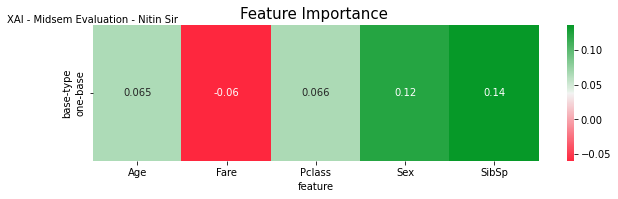

In [39]:
    # Since Captum is not directly
    # made for Lightning,
    # we need this wrapper
    def modified_f(in_vec):
        # Changes the shapes correctly
        # X:Shape([SAMPLE_DIM*STEP_AMOUNT]=250)
        x = torch.reshape(in_vec,
                          (int(
                              in_vec.size()[
                                  0] / SAMPLE_DIM),
                           SAMPLE_DIM)
                          )
        # RES:Shape([50,5])
        # Since we have 50ti Batches and 5 features
        model.to(device)
        res = model.forward(x)
        # Again reshape to correct dims
        res = torch.reshape(res, (
            res.size()[0], 1))
        return res


    STEP_AMOUNT = 250
    ig = IntegratedGradients(modified_f)
    # Test to understand the basics
    # First get the 6th test example
    val = ts.__getitem__(6)[0]
    print("IN X1:", val)
    # Predict the importance of the features
    # for the male example
    imp_m = ig.attribute(inputs=val,
                         baselines=ts.base,
                         n_steps=STEP_AMOUNT)
    print("IMPORTANCE X_m:", imp_m)
    print("Probability SURVIVAl X_m:",
          modified_f(val))
    # Predict the importance of the features
    # for the female example
    print(
        "Let's Change the gender ->X2")
    val_f = val
    val_f[1] = 0
    imp_f = ig.attribute(inputs=val_f,
                         baselines=ts.base,
                         n_steps=STEP_AMOUNT)
    print("IMPORTANCE X_f:", imp_f)
    print("Probability SURVIVAl  X_f:",
          modified_f(val_f))
    # Compare each element of the test set to out baselines
    # we will than use this
    for i in range(0,
                   ts.__len__()):
        # load our test example
        in_val = ts.__getitem__(i)[0]
        # compare it to the 4 baselines
        att_b = ig.attribute(
            inputs=in_val,
            baselines=ts.base,
            n_steps=STEP_AMOUNT)
        att_r = ig.attribute(
            inputs=in_val,
            baselines=torch.rand(
                5).cuda(),
            n_steps=STEP_AMOUNT)
        att_z = ig.attribute(
            inputs=in_val,
            baselines=torch.zeros(
                5).cuda(),
            n_steps=STEP_AMOUNT)
        att_1 = ig.attribute(
            inputs=in_val,
            baselines=torch.ones(
                5).cuda(),
            n_steps=STEP_AMOUNT)
        # att_b = torch.from_numpy(att_b).float().to(device)
        # att_r = torch.from_numpy(att_r).float().to(device)
        # att_n = torch.from_numpy(att_n).float().to(device)
        # att_z = torch.from_numpy(att_z).float().to(device)
        # att_1 = torch.from_numpy(att_1).float().to(device)
        # save result, this will produce a df
        # you can skip the details
        for base_type, vals in [
            ("mean-base", att_b),
            ("random-base", att_r),
            ("zero-base", att_z),
            ('one-base', att_1),
        ]:
            for i, name in enumerate(['Pclass',
                                      "Sex",
                                      "Age",
                                      "SibSp",
                                      "Fare"]):
                to_be_df.append({
                    "base-type": base_type,
                    "feature": name,
                    "value": vals[i],
                    "epoch": max_epoch
                })
    df = pd.DataFrame(to_be_df)
    df.to_csv('data/interpretation_results.csv')
    # Aggregate and Visualize
    # Load Data
    df = pd.read_csv('data/interpretation_results.csv', header=0, encoding='ascii', engine='python')
    # df = pd.read_csv('data/interpretation_results.csv', sep=r'\s*,\s*', engine='python', skipinitialspace=True)
    print('********************************')
    print(df.columns)
    # Defined the color map for our heatmap to be red to green
    cmap = sns.diverging_palette(h_neg=10, h_pos=130, s=99,
                                 l=55, sep=3, as_cmap=True)
    # Aggregate the CSV by mean
    df['value'] = [float(s.split(',')[0].split('(')[1]) for s in df['value']]
    # func = lambda x: x.mean()
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df = df.groupby(["base-type", 'feature', 'epoch'],as_index=False).mean()
    print(")))))))))))))))))))))))00")
    # lulz wrong group_by p
    # df = df.groupby(["base-type", 'feature', 'epoch'],
    #                 as_index=False)['value']
    print('^^^^^^^^^^^^^^^^^^^^^')
    print(df.columns)
    df = df[df['epoch'] == max_epoch]
    # Make one plot per baseline to compare
    for b in ["mean-base",
              "random-base",
              "zero-base",
              'one-base']:

        # Create a pivot frame
        tmp = df[df['base-type'] == b]
        # Create a pivot frame
        print('---------------------------------------------------------------------')
        print(list(tmp.columns))
        tmp = tmp.pivot(index='base-type', columns='feature', values='value')
        print("We will plot:\n",tmp)
        # tmp = df[df['base-type'] == b]
        # tmp = tmp.pivot(index='base-type',
        #                 columns='feature',
        #                 values='value')
        # Some code to make a heatmap using seaborn
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 2.5)

        plt.title("Feature Importance ", fontsize=15)
        sns.heatmap(tmp, ax=ax, cmap=cmap, annot=True)
        plt.text(0, 0,
                 'XAI - Midsem Evaluation - Nitin Sir',
                 horizontalalignment='center',
                 verticalalignment='bottom',
                 fontsize=10)

        plt.savefig(f'data/{b}.png')

In [35]:
df = pd.read_csv('data/interpretation_results.csv', header=0, encoding='ascii', engine='python')
# df = pd.read_csv('data/interpretation_results.csv', sep=r'\s*,\s*', engine='python', skipinitialspace=True)
print('********************************')
print(df.columns)
print('________________________________&&&&&&&&&&&&&&&&&&&&77')
print((df['value'][0]))
print('________________________________&&&&&&&&&&&&&&&&&&&&77')
# # Defined the color map for our heatmap to be red to green
cmap = sns.diverging_palette(h_neg=10, h_pos=130, s=99,
                               l=55, sep=3, as_cmap=True)
# # Aggregate the CSV by mean
df['value'] = [float(s.split(',')[0].split('(')[1]) for s in df['value']]
func = lambda x: x.mean()
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.groupby(["base-type", 'feature', 'epoch'],as_index=False).mean()
print(")))))))))))))))))))))))00")
df
# print('^^^^^^^^^^^^^^^^^^^^^')
# print(df.columns)

********************************
Index(['Unnamed: 0', 'base-type', 'feature', 'value', 'epoch'], dtype='object')
________________________________&&&&&&&&&&&&&&&&&&&&77
tensor(0.1781, device='cuda:0', dtype=torch.float64)
________________________________&&&&&&&&&&&&&&&&&&&&77
)))))))))))))))))))))))00


,base-type,feature,epoch,value
0,mean-base,Age,20,0.001192
1,mean-base,Fare,20,0.000267
2,mean-base,Pclass,20,0.013660
3,mean-base,Sex,20,0.053709
4,mean-base,SibSp,20,0.001090
5,one-base,Age,20,0.065101
6,one-base,Fare,20,-0.059897
7,one-base,Pclass,20,0.065766
8,one-base,Sex,20,0.122510
9,one-base,SibSp,20,0.136250
